# Collaborative Filtering

In [ ]:
!pip install -q matplotlib==3.7.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 967.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 26.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.3 which is incompatible.


In [ ]:
!pip install -q surprise
!pip install -q recmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.6/243.6 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.1 MB/s et

In [ ]:
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from surprise import Reader, AlgoBase, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate, KFold

import recmetrics

# Set a concrete seed to make results reproducible
import random
my_seed = 1234

### Data load & prep

In [4]:
business_df_sampled = pd.read_pickle("business_sampled.pkl")
business_df_sampled.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."


In [5]:
review_df_sampled = pd.read_pickle("reviews_sampled.pkl")

In [6]:
review_df_sampled['stars'].max()

5

In [7]:
review_df_sampled['stars'].min()

1

In [8]:
reader = Reader(rating_scale=(1, 5))
review_data = Dataset.load_from_df(review_df_sampled[['user_id', 'business_id', 'stars']], reader)

In [9]:
print(f"There are {review_df_sampled['user_id'].nunique()} unique users")
print(f"There are {review_df_sampled['business_id'].nunique()} unique restaurants")
print(f"There are {review_df_sampled.shape[0]} ratings")

There are 100000 unique users
There are 52056 unique restaurants
There are 2262172 ratings


In [10]:
mean = review_df_sampled['stars'].mean()
std = review_df_sampled['stars'].std()
print(f'The ratings mean is {round(mean, 2)} and std is {round(std, 4)}')

The ratings mean is 3.83 and std is 1.2262


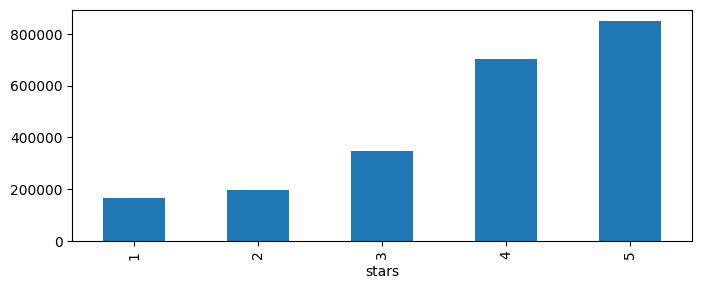

In [ ]:
plt.subplots(figsize=(8,3))
review_df_sampled.groupby('stars').size().plot.bar();

Merge review.json with business.json to incorporate restaurant details.

### Fit the model

Model based collaborative filtering - suprise library

In [ ]:
algo = SVD(random_state=my_seed)

In [12]:
trainset, testset = train_test_split(review_data, test_size=.20, random_state=my_seed)

In [ ]:
algo.fit(trainset);

Accuracy

In [ ]:
predictions = algo.test(testset)
accuracy.rmse(predictions);
accuracy.mae(predictions);

RMSE: 1.0875
MAE:  0.8516


### Result Exploration I

#### Coverage

In [ ]:
# Get the full catalog of items (raw business_ids) from the trainset
catalog = [trainset.to_raw_iid(inner_iid) for inner_iid in trainset.all_items()]
print("Catalog size:", len(catalog))

Catalog size: 51840


In [ ]:
def get_top_n(predictions, n=10, solve_ties=False):
    from collections import defaultdict
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
        solve_ties(bool): Solve prediction ties by using the item id.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        if solve_ties:
            user_ratings.sort(key=lambda x: (x[1], x[0]), reverse=True)
        else:
            user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_n = get_top_n(predictions, n=5)

In [ ]:
top_n_only_items  = [[iid for (iid, _) in user_ratings] for user_ratings in top_n.values()]

In [ ]:
def prediction_coverage(top_n_list, catalog):
    """
    top_n_list: list of lists, where each inner list contains item_ids recommended to a user.
    catalog: list of all possible item_ids.
    Returns coverage as a percentage.
    """
    recommended_items = set()
    for user_ratings in top_n_list:
        recommended_items.update(user_ratings)
    coverage = (len(recommended_items) / len(catalog)) * 100
    return coverage

coverage_cf   = prediction_coverage(top_n_only_items, catalog)

print("Coverage for CF Recommender:  {:.2f}%".format(coverage_cf))

Coverage for CF Recommender:  76.17%


#### Personalilzation

In [ ]:
# For example, sample 10,000 users from your top_n_only_items list
import random
sample_size = 10000
if len(top_n_only_items) > sample_size:
    sampled_top_n = random.sample(top_n_only_items, sample_size)
else:
    sampled_top_n = top_n_only_items

# Convert each inner list to tuple for hashability
sampled_top_n_tuples = [tuple(item_list) for item_list in sampled_top_n]
personalization_cf = recmetrics.personalization(sampled_top_n_tuples)
print("Personalization Score (sampled):", personalization_cf)

/usr/local/lib/python3.11/dist-packages/recmetrics/metrics.py:186: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predicted = np.array(predicted)


Personalization Score (sampled): 0.9999965396539654


#### Diversity

In [24]:
business_onehot = business_df_sampled[['business_id']].join(
    business_df_sampled['categories'].str.get_dummies(sep=', ')
).set_index('business_id')

business_onehot.head()

,Acai Bowls,Accessories,Accountants,Active Life,Adult,Adult Education,Adult Entertainment,Advertising,Afghan,African,...,Wine & Spirits,Wine Bars,Wine Tasting Classes,Wine Tasting Room,Wine Tours,Wineries,Women's Clothing,Wraps,Yelp Events,Yoga
business_id,,,,,,,,,,,,,,,,,,,,,
MTSW4McQd7CbVtyjqoe9mw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CF33F8-E6oudUQ46HnavjQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bBDDEgkFA1Otx9Lfe7BZUQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
eEOYSgkmpB90uNA7lDOMRA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
il_Ro8jwPlHresjw9EGmBg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
valid_top_n_only_items = [
    [iid for iid in rec_list if iid in business_onehot.index]
    for rec_list in top_n_only_items
]

# Filter out lists that have fewer than 2 items:
valid_top_n_only_items = [rec_list for rec_list in valid_top_n_only_items if len(rec_list) >= 2]

# Now compute diversity with the filtered recommendations
diversity_cf = recmetrics.intra_list_similarity(valid_top_n_only_items, business_onehot)
print("Diversity (Intra-List Similarity) for CF recommendations:", diversity_cf)

Diversity (Intra-List Similarity) for CF recommendations: 0.3269664765211675


In [ ]:
model_names = ['CF']
coverage_scores = [coverage_cf]
personalization_scores = [personalization_cf]
intra_list_similarity_scores = [diversity_cf]

# Plot the metrics for the CF model
recmetrics.metrics_plot(
    model_names=model_names,
    coverage_scores=coverage_scores,
    personalization_scores=personalization_scores,
    intra_list_similarity_scores=intra_list_similarity_scores
)

#### CV

In [ ]:
#needs 5 min to run
performance = cross_validate(algo, review_data, measures=['RMSE', 'MAE'],
                             cv=KFold(n_splits=5, random_state=my_seed),
                             return_train_measures=True, verbose=True, n_jobs=-1)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0849  1.0865  1.0855  1.0882  1.0875  1.0865  0.0012  
MAE (testset)     0.8493  0.8509  0.8504  0.8528  0.8516  0.8510  0.0012  
RMSE (trainset)   0.7745  0.7750  0.7751  0.7746  0.7745  0.7748  0.0002  
MAE (trainset)    0.6069  0.6072  0.6072  0.6070  0.6067  0.6070  0.0002  
Fit time          62.06   58.91   50.76   47.72   27.45   49.38   12.14   
Test time         6.60    7.63    7.82    6.27    3.95    6.45    1.38    


### Result exploration II

#### Workflow 1: Actual Top‑N Recommendations for Unrated Items (Real User Experience)

In [ ]:
from tqdm import tqdm

all_user_ids = trainset.all_users()     # internal IDs
all_item_ids = trainset.all_items()     # internal IDs

In [ ]:
# Convert internal IDs back to raw IDs (the original user_id, business_id)
all_user_raw_ids = [trainset.to_raw_uid(u) for u in all_user_ids]
all_item_raw_ids = [trainset.to_raw_iid(i) for i in all_item_ids]

- retrieve the list of items they’ve already rated.
- identify items they haven’t rated.
- For each of these unrated items, you predict the rating using your SVD model (algo).
- Sort the predictions by the highest estimated rating and pick the top 5.

In [ ]:
from tqdm import tqdm

top_n_recs = {}
# Only consider the first 1000 users for demonstration
for user_internal_id in tqdm(all_user_ids[:1000]):
    user_raw_id = trainset.to_raw_uid(user_internal_id)

    # Get all items the user has already rated
    rated_items = set([trainset.to_raw_iid(j) for (j, _) in trainset.ur[user_internal_id]])

    # Build a list of items not yet rated
    not_rated_items = [iid for iid in all_item_raw_ids if iid not in rated_items]

    # Predict rating for each not-rated item
    predictions = []
    for item_id in not_rated_items:
        pred = algo.predict(user_raw_id, item_id)
        predictions.append((item_id, pred.est))

    # Sort predictions by estimated rating in descending order and choose top 5
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_n = predictions[:5]
    top_n_recs[user_raw_id] = top_n

100%|██████████| 1000/1000 [06:28<00:00,  2.57it/s]


In [ ]:
rows = []
for user_id, recs in top_n_recs.items():
    for (item_id, rating_est) in recs:
        rows.append((user_id, item_id, rating_est))

recs_df = pd.DataFrame(rows, columns=['user_id', 'business_id', 'predicted_rating'])
print("Top-N Recommendations:")
recs_df.head()

Top-N Recommendations:


,user_id,business_id,predicted_rating
0,3eq2wJ3ng8MOymUEC_FQvQ,3qsHL1xuMPlPqQciHNYkeg,5.0
1,3eq2wJ3ng8MOymUEC_FQvQ,1FYdMkv1bc-sKUrjalyKxQ,5.0
2,3eq2wJ3ng8MOymUEC_FQvQ,RqW9S4WG9UYZHKhHRHXJZg,5.0
3,3eq2wJ3ng8MOymUEC_FQvQ,NHb6QTrJOnyIj-Zd0fYzFg,5.0
4,3eq2wJ3ng8MOymUEC_FQvQ,vyOVT4bcW227LRwJGHTeSw,5.0


In [ ]:
merged_recs = recs_df.merge(
    business_df_sampled[['business_id', 'name', 'city', 'categories']],
    on='business_id',
    how='left'
)
print("Merged with Business Info:")
merged_recs.head()

Merged with Business Info:


,user_id,business_id,predicted_rating,name,city,categories
0,3eq2wJ3ng8MOymUEC_FQvQ,3qsHL1xuMPlPqQciHNYkeg,5.0,Anello,Tucson,"Pizza, Restaurants"
1,3eq2wJ3ng8MOymUEC_FQvQ,1FYdMkv1bc-sKUrjalyKxQ,5.0,Hole In One Donut,Tampa,"Restaurants, Donuts, Breakfast & Brunch, Food"
2,3eq2wJ3ng8MOymUEC_FQvQ,RqW9S4WG9UYZHKhHRHXJZg,5.0,Lolis Mexican Cravings,Tampa,"Ethnic Food, Restaurants, Specialty Food, Mexi..."
3,3eq2wJ3ng8MOymUEC_FQvQ,NHb6QTrJOnyIj-Zd0fYzFg,5.0,Bogart's Smokehouse,Saint Louis,"Food, Event Planning & Services, American (Tra..."
4,3eq2wJ3ng8MOymUEC_FQvQ,vyOVT4bcW227LRwJGHTeSw,5.0,Buena Onda,Santa Barbara,"Event Planning & Services, Latin American, Cat..."


In [ ]:
user_df_sampled = pd.read_pickle("user_sampled.pkl")
user_df_sampled.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0
5,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1221,2005-03-14 20:26:35,14953,9940,11211,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",1357,...,163,191,361,147,1212,5696,2543,2543,815,323
6,cxuxXkcihfCbqt5Byrup8Q,Rob,12,2009-02-24 03:09:06,6,1,0,,"HDAQ74AEznP-YsMk1B14CA, 6A6-aIX7fg_zRy9MiE6YyQ...",1,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
final_df = merged_recs.merge(
    user_df_sampled[['user_id', 'name']],  # add other columns if needed
    on='user_id',
    how='left'
)

print("Final Merged DataFrame with User Information:")
display(final_df.head())

Final Merged DataFrame with User Information:


,user_id,business_id,predicted_rating,name_x,city,categories,name_y
0,3eq2wJ3ng8MOymUEC_FQvQ,3qsHL1xuMPlPqQciHNYkeg,5.0,Anello,Tucson,"Pizza, Restaurants",Paul
1,3eq2wJ3ng8MOymUEC_FQvQ,1FYdMkv1bc-sKUrjalyKxQ,5.0,Hole In One Donut,Tampa,"Restaurants, Donuts, Breakfast & Brunch, Food",Paul
2,3eq2wJ3ng8MOymUEC_FQvQ,RqW9S4WG9UYZHKhHRHXJZg,5.0,Lolis Mexican Cravings,Tampa,"Ethnic Food, Restaurants, Specialty Food, Mexi...",Paul
3,3eq2wJ3ng8MOymUEC_FQvQ,NHb6QTrJOnyIj-Zd0fYzFg,5.0,Bogart's Smokehouse,Saint Louis,"Food, Event Planning & Services, American (Tra...",Paul
4,3eq2wJ3ng8MOymUEC_FQvQ,vyOVT4bcW227LRwJGHTeSw,5.0,Buena Onda,Santa Barbara,"Event Planning & Services, Latin American, Cat...",Paul


##### Coverage

 Determine how many unique restaurants are recommended across all users.

In [ ]:
recommended_businesses = final_df['business_id'].unique()
item_coverage = len(recommended_businesses)
print("Item Coverage:", item_coverage)

Item Coverage: 772


##### User Coverage

In [ ]:
users_with_recs = final_df['user_id'].nunique()
print("User Coverage:", users_with_recs)

User Coverage: 1000


##### Category Diversity

In [ ]:
category_counts = final_df['categories'].value_counts()
print("Top 10 Categories in Recommendations:")
category_counts.head(10)

Top 10 Categories in Recommendations:


,count
categories,
"Pizza, Restaurants",246
"Restaurants, Donuts, Breakfast & Brunch, Food",212
"Food, Restaurants, Cafes, Creperies, Coffee & Tea",168
"Active Life, Event Planning & Services, Hotels & Travel, Hotels, Restaurants, Beaches",105
"Asian Fusion, Food Trucks, Food, Restaurants, Hawaiian",86
"Sandwiches, Delis, Restaurants, Food, Meat Shops, Specialty Food",81
"Kombucha, Juice Bars & Smoothies, Cafes, Restaurants, Food, Coffee & Tea",80
"Beer Bar, Vegetarian, Greek, Bars, Mediterranean, Turkish, American (Traditional), American (New), Nightlife, Restaurants",79
"Convenience Stores, Italian, Specialty Food, Mexican, Restaurants, Food",77


#####  Intra-list Similarity

Goal: Measure how similar the items in a single user’s top‑N list are to each other.

Implementation Idea:
- Represent each restaurant by a category vector or embedding, then compute the average pairwise similarity for the N items. A lower average similarity means a more diverse set of recommendations.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(', '))
vectorizer.fit(final_df['categories'].fillna(''))  # handle NaN by filling with empty string

# Now we can transform categories into vectors
def get_category_vector(cat_str):
    if pd.isna(cat_str):
        cat_str = ''
    return vectorizer.transform([cat_str])

# Quick test
example_str = "Mexican, Restaurants, Bars"
print(get_category_vector(example_str))

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3 stored elements and shape (1, 241)>
  Coords	Values
  (0, 19)	1
  (0, 148)	1
  (0, 188)	1


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Group the final_df by user, so we can compute ILS per user
grouped = final_df.groupby('user_id')

user_ils = []  # store each user's intra-list similarity
for user_id, group in grouped:
    if len(group) < 2:
        continue

    # Build a matrix of category vectors for these recommended items
    vectors = []
    for idx, row in group.iterrows():
        cat_vec = get_category_vector(row['categories'])
        vectors.append(cat_vec.toarray()[0])  # convert sparse to dense array

    # Convert list of arrays to a single 2D array
    vectors = np.vstack(vectors)

    # Compute the pairwise cosine similarity among the top-N items
    sim_matrix = cosine_similarity(vectors, vectors)

    # We only need the upper-triangular (or lower) part to compute the average pairwise similarity
    # Exclude the diagonal (self-similarity)
    n = len(group)
    # sum of upper-triangular off-diagonal
    upper_tri_sum = np.sum(np.triu(sim_matrix, k=1))
    # number of pairs
    num_pairs = (n * (n - 1)) / 2

    ils_u = upper_tri_sum / num_pairs
    user_ils.append(ils_u)

# Compute the average ILS across users
avg_ils = np.mean(user_ils) if user_ils else None

print(f"Average Intra-List Similarity (ILS): {avg_ils:.4f}" if avg_ils is not None else "No data")

Average Intra-List Similarity (ILS): 0.2629


suggests that, on average, your recommended items are not highly similar to each other—i.e., they’re reasonably diverse.

##### Displaying Recommendations for a Sample User


In [ ]:
# Pick a random user (or a few) from the top_n_recs
sample_user = list(top_n_recs.keys())[0]  # first user in dict

user_recs = final_df[merged_recs['user_id'] == sample_user]
print(f"Recommendations for user {sample_user}:")
display(user_recs)

Recommendations for user 3eq2wJ3ng8MOymUEC_FQvQ:


,user_id,business_id,predicted_rating,name_x,city,categories,name_y
0,3eq2wJ3ng8MOymUEC_FQvQ,3qsHL1xuMPlPqQciHNYkeg,5.0,Anello,Tucson,"Pizza, Restaurants",Paul
1,3eq2wJ3ng8MOymUEC_FQvQ,1FYdMkv1bc-sKUrjalyKxQ,5.0,Hole In One Donut,Tampa,"Restaurants, Donuts, Breakfast & Brunch, Food",Paul
2,3eq2wJ3ng8MOymUEC_FQvQ,RqW9S4WG9UYZHKhHRHXJZg,5.0,Lolis Mexican Cravings,Tampa,"Ethnic Food, Restaurants, Specialty Food, Mexi...",Paul
3,3eq2wJ3ng8MOymUEC_FQvQ,NHb6QTrJOnyIj-Zd0fYzFg,5.0,Bogart's Smokehouse,Saint Louis,"Food, Event Planning & Services, American (Tra...",Paul
4,3eq2wJ3ng8MOymUEC_FQvQ,vyOVT4bcW227LRwJGHTeSw,5.0,Buena Onda,Santa Barbara,"Event Planning & Services, Latin American, Cat...",Paul


##### Recommendation frequency

In [ ]:
# Group by business_id, name, city, and count how many times each appears
top_business_info = (
    final_df
    .groupby(['business_id', 'name_x', 'city'], as_index=False)
    .size()  # size() counts rows in each group
    .rename(columns={'size': 'recommendation_count'})
    .sort_values('recommendation_count', ascending=False)
    .head(10)
)

print("Top 10 most frequently recommended restaurants (with name and city):")
display(top_business_info)

Top 10 most frequently recommended restaurants (with name and city):


,business_id,name_x,city,recommendation_count
45,3qsHL1xuMPlPqQciHNYkeg,Anello,Tucson,239
23,1FYdMkv1bc-sKUrjalyKxQ,Hole In One Donut,Tampa,212
613,tARR9jhv5gi9TjsfSVmjmw,Kaffe Crepe,Reno,168
167,EDRhPfxELquxtMOGuNKFTw,Pass-A-Grille Beach,Pass-a-Grille Beach,105
489,gjHB6p19V_bS-R5lUZux4A,South Pacific Grill,Brandon,86
275,Orvi9NZMyy4p1kGSe8WBow,Kincaid's Meat Market,Indianapolis,81
71,5wlbureqTc6gsaB_y-OkOA,Bovaconti Coffee,Indianapolis,80
390,YnGlopjmCYM6Pw07qt9bfw,Mio’s Grill & Cafe,St. Petersburg,79
323,TE2IEDNV0RcI6s1wTOP4fg,Tortilleria San Roman,Philadelphia,77
528,jh8j-DWqgWkbRe_a2XtKFQ,Barrio Bread,Tucson,70


This block calculates how often each restaurant appears in the top recommendations across all users (in the sample). It provides insight into which restaurants are being recommended most frequently, which can help you understand if the model is biased toward certain items.

#### Workflow 2: Model Evaluation on the Test Set

In [ ]:
from collections import defaultdict
from sklearn import metrics

test_ratings_df = pd.DataFrame(testset, columns=['user_id', 'business_id', 'true_rating'])

# 2. Generate predictions for each row in test_ratings_df
predictions_dict = defaultdict(list)
for idx, row in test_ratings_df.iterrows():
    user = row['user_id']
    business = row['business_id']
    actual_rating = row['true_rating']

    # Predict rating using your trained SVD model
    pred = algo.predict(user, business)

    # Store (business_id, actual_rating, predicted_rating) for this user
    predictions_dict[user].append((business, actual_rating, pred.est))

In [ ]:
def precision_at_k(relevant_set, recommended_list, k):
    if k == 0:
        return 0.0
    hit_count = sum((item in relevant_set) for item in recommended_list[:k])
    return hit_count / k

In [ ]:
def recall_at_k(relevant_set, recommended_list, k):
    if len(relevant_set) == 0:
        return 0.0
    hit_count = sum((item in relevant_set) for item in recommended_list[:k])
    return hit_count / len(relevant_set)

In [ ]:
def ndcg_at_k(relevance_scores, k):
    return metrics.ndcg_score([relevance_scores], [relevance_scores], k=k)

In [ ]:
def compute_user_metrics(user_data, k=5, relevance_threshold=4.0):
    if len(user_data) < 2:
        # Not enough data to compute ranking metrics meaningfully
        return None

    # Sort user_data by predicted_rating descending
    user_data_sorted = sorted(user_data, key=lambda x: x[2], reverse=True)

    # Extract the top-k items by predicted rating
    top_k_items = user_data_sorted[:k]

    # Build a list of recommended item_ids in top-k
    recommended_list = [x[0] for x in top_k_items]

    # Build a set of relevant items from the user's entire test data
    # (not just the top-k, but all items in user_data)
    relevant_set = set()
    for (business_id, actual_rating, _) in user_data:
        if actual_rating >= relevance_threshold:
            relevant_set.add(business_id)

    # Build a binary relevance list for NDCG
    # 1 if actual_rating >= threshold, else 0
    relevance_scores = []
    for (business_id, actual_rating, _) in user_data_sorted:
        relevance_scores.append(1 if actual_rating >= relevance_threshold else 0)

    # Compute metrics
    p_at_k = precision_at_k(relevant_set, recommended_list, k)
    r_at_k = recall_at_k(relevant_set, recommended_list, k)
    ndcg_k = ndcg_at_k(relevance_scores, k)

    return (p_at_k, r_at_k, ndcg_k)

In [ ]:
print("Number of users in predictions_dict:", len(predictions_dict))

Number of users in predictions_dict: 93521


In [ ]:
k = 5
precision_list = []
recall_list = []
ndcg_list = []

for user, user_data in predictions_dict.items():
    metrics_user = compute_user_metrics(user_data, k=k, relevance_threshold=4.0)
    if metrics_user is not None:
        p_at_k, r_at_k, ndcg_k = metrics_user
        precision_list.append(p_at_k)
        recall_list.append(r_at_k)
        ndcg_list.append(ndcg_k)

avg_precision = np.mean(precision_list) if precision_list else 0
avg_recall = np.mean(recall_list) if recall_list else 0
avg_ndcg = np.mean(ndcg_list) if ndcg_list else 0

print(f"Precision@{k}: {avg_precision:.4f}")
print(f"Recall@{k}:    {avg_recall:.4f}")
print(f"NDCG@{k}:      {avg_ndcg:.4f}")

Precision@5: 0.5230
Recall@5:    0.8495
NDCG@5:      0.9447


##### Comparison of ratings

In [ ]:
comparison_rows = []
for idx, row in test_ratings_df.iterrows():
    user = row['user_id']
    business = row['business_id']
    true_rating = row['true_rating']

    # Predict rating using your trained model (algo)
    pred = algo.predict(user, business)
    predicted_rating = pred.est
    abs_error = abs(true_rating - predicted_rating)

    comparison_rows.append((user, business, true_rating, predicted_rating, abs_error))


comparison_df = pd.DataFrame(comparison_rows, columns=['user_id', 'business_id', 'true_rating', 'predicted_rating', 'abs_error'])
print("Comparison of True vs. Predicted Ratings:")
display(comparison_df.head())

Comparison of True vs. Predicted Ratings:


,user_id,business_id,true_rating,predicted_rating,abs_error
0,nlQGyti20c07rpTSYYoNZQ,qDheewhaZNDWLfpsrrrRiw,4.0,3.759934,0.240066
1,nraF3Nvr2VfJ-3EtQE1mnA,B3CY2NVEFySzbyhW9YuxQg,5.0,3.429586,1.570414
2,eWz41dtIs-H2JeV3JYQFsQ,0r37WEgkjlpioz0Ftdp6Zg,1.0,2.926318,1.926318
3,cMEtAiW60I5wE_vLfTxoJQ,iSRTaT9WngzB8JJ2YKJUig,4.0,3.339560,0.660440
4,VnmVTEsmQ2aBeY4XuLyvig,9xdXS7jtWjCVzL4_oPGv9A,2.0,4.481970,2.481970


In [ ]:
merged_df = comparison_df.merge(
    business_df_sampled[['business_id', 'name', 'city', 'categories']],
    on='business_id',
    how='left'
)
print("Merged with Business Info:")
display(merged_df.head())

Merged with Business Info:


,user_id,business_id,true_rating,predicted_rating,abs_error,name,city,categories
0,nlQGyti20c07rpTSYYoNZQ,qDheewhaZNDWLfpsrrrRiw,4.0,3.759934,0.240066,NaN,NaN,NaN
1,nraF3Nvr2VfJ-3EtQE1mnA,B3CY2NVEFySzbyhW9YuxQg,5.0,3.429586,1.570414,Taco Bell,Camby,"Restaurants, Tex-Mex, Mexican, Tacos, Fast Foo..."
2,eWz41dtIs-H2JeV3JYQFsQ,0r37WEgkjlpioz0Ftdp6Zg,1.0,2.926318,1.926318,ShopRite of Bensalem,Bensalem,"Grocery, Food, Bakeries, Beer, Wine & Spirits,..."
3,cMEtAiW60I5wE_vLfTxoJQ,iSRTaT9WngzB8JJ2YKJUig,4.0,3.339560,0.660440,Mother's Restaurant,New Orleans,"Cajun/Creole, Restaurants, Event Planning & Se..."
4,VnmVTEsmQ2aBeY4XuLyvig,9xdXS7jtWjCVzL4_oPGv9A,2.0,4.481970,2.481970,GW Fins,New Orleans,"Seafood, Gluten-Free, Vegetarian, Restaurants"


##### Auxiliary dataframe

In [ ]:
predictions = algo.test(testset)

In [ ]:
print(type(predictions[0]))
print(predictions[0])

<class 'surprise.prediction_algorithms.predictions.Prediction'>
user: nlQGyti20c07rpTSYYoNZQ item: qDheewhaZNDWLfpsrrrRiw r_ui = 4.00   est = 3.76   {'was_impossible': False}


In [ ]:
# Build the auxiliary DataFrame from the test set predictions
pred_df = pd.DataFrame([(x.r_ui, x.est) for x in predictions],
                       columns=['true_rating', 'predicted_rating'])
pred_df.head()

,true_rating,predicted_rating
0,4.0,3.759934
1,5.0,3.429586
2,1.0,2.926318
3,4.0,3.339560
4,2.0,4.481970


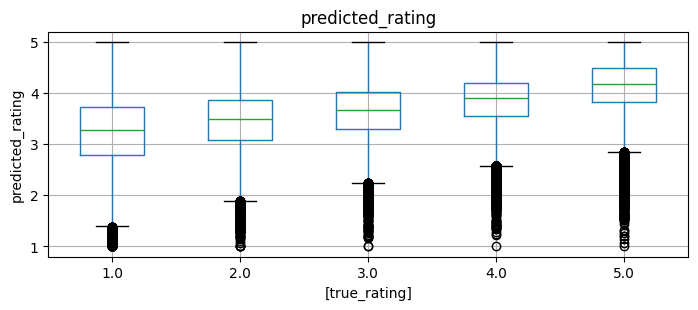

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 3))
pred_df.boxplot(by="true_rating", ax=ax)
bp_fig = ax.get_figure()
bp_fig.suptitle('')
ax.set_ylabel('predicted_rating')
plt.show()

- Whiskers and Outliers: Some predictions are significantly higher or lower than the rest, represented by the dots. These are “outlier” predictions.

- For each true rating bucket, there’s a range of predicted values.

- When the true rating is 5.0, many predictions are around 4.0–5.0, but there are some outliers that are lower.

- When the true rating is 1.0, the median predicted rating is still above 2.0 (for example), suggesting the model tends not to predict very low values. This could be due to fewer low ratings in the training data or the model’s inherent bias toward mid-range predictions.

- The boxplot confirms the model reduces uncertainty compared to a naive approach (e.g., always predicting 3.5).

- It’s not perfect—especially at the extremes—but it generally ranks higher-rated items above lower-rated ones, which is what you want in a recommendation context.

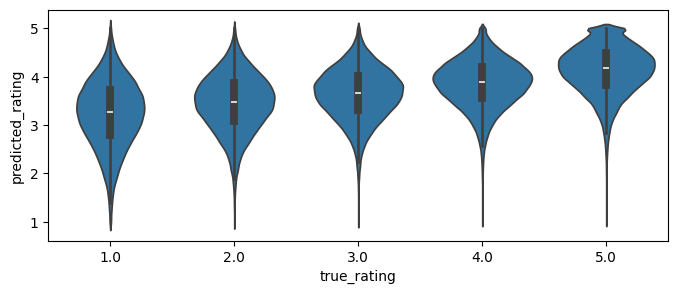

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 3))
sns.violinplot(data=pred_df, x="true_rating", y="predicted_rating", ax=ax)
plt.show()

- As with the boxplot, you can see that higher true ratings generally correspond to higher predicted ratings.

- The distribution “shifts” to the right (towards higher predicted ratings) for true rating = 4.0 and 5.0.

- The model captures the overall trend—items with higher true ratings have higher predicted ratings.

- The model might struggle with very low-rated items, often predicting them around 2–3 instead of 1–2.

- Some 5.0-rated items are predicted at 3.5–4.0, showing that while the model knows these items are above average, it doesn’t always confidently predict a 5.

### Hyperparameter tuning

In [ ]:
from surprise.model_selection import GridSearchCV
from surprise import SVD, Dataset

# Assume you have a Surprise Dataset called 'data'
# (created from your review_df or similar).
param_grid = {
    'n_factors': [20, 50, 100],
    'reg_all': [0.02, 0.05, 0.1]
}

gs = GridSearchCV(
    SVD,
    param_grid,
    measures=['rmse', 'mae'],  # or 'rmse', 'mae', 'fcp'
    cv=3,  # 3-fold CV to save compute
    n_jobs=-1,  # use all CPU cores for speed
    joblib_verbose=2  # optional: show progress
)

gs.fit(review_data)

# Print best RMSE score
print(gs.best_score['rmse'])
# Print the combination of parameters that gave the best RMSE
print(gs.best_params['rmse'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


1.0829488606181028
{'n_factors': 20, 'reg_all': 0.1}


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  9.7min finished


In [13]:
# Create the final model using the best hyperparameters
final_algo = SVD(n_factors=20, reg_all=0.1, random_state=my_seed)

# Retrain the model on the full training set (from your earlier train_test_split)
final_algo.fit(trainset)

In [14]:
# Get predictions on the test set using the final tuned model
predictions = final_algo.test(testset)

# For offline evaluation, create a DataFrame from these predictions
# Each prediction is a Surprise Prediction object with attributes: uid, iid, r_ui, est, etc.
pred_df = pd.DataFrame([(pred.uid, pred.iid, pred.r_ui, pred.est) for pred in predictions],
                       columns=['user_id', 'business_id', 'true_rating', 'predicted_rating'])
print("Test Set Predictions Comparison:")
display(pred_df.head())

Test Set Predictions Comparison:


,user_id,business_id,true_rating,predicted_rating
0,nlQGyti20c07rpTSYYoNZQ,qDheewhaZNDWLfpsrrrRiw,4.0,3.947565
1,nraF3Nvr2VfJ-3EtQE1mnA,B3CY2NVEFySzbyhW9YuxQg,5.0,3.442246
2,eWz41dtIs-H2JeV3JYQFsQ,0r37WEgkjlpioz0Ftdp6Zg,1.0,2.793227
3,cMEtAiW60I5wE_vLfTxoJQ,iSRTaT9WngzB8JJ2YKJUig,4.0,3.794896
4,VnmVTEsmQ2aBeY4XuLyvig,9xdXS7jtWjCVzL4_oPGv9A,2.0,4.389405


In [15]:
print("Final Model RMSE:", accuracy.rmse(predictions, verbose=True))
print("Final Model MAE:", accuracy.mae(predictions, verbose=True))

RMSE: 1.0779
Final Model RMSE: 1.0779488845703868
MAE:  0.8474
Final Model MAE: 0.8474327672186432


In [16]:
from sklearn import metrics
import numpy as np

def ndcg_multiple_users(relevant_items_all_users, predictions_ranking_all_users, k=5):
    ndcg_list = []
    # Loop over each user
    for i in range(len(relevant_items_all_users)):
        # Skip users with only one item in the test data, as NDCG cannot be computed reliably
        if len(relevant_items_all_users[i]) > 1:
            ndcg = metrics.ndcg_score([relevant_items_all_users[i]],
                                      [predictions_ranking_all_users[i]], k=k)
            ndcg_list.append(ndcg)
    return np.mean(ndcg_list)

# Convert test predictions to an auxiliary DataFrame for ranking metrics.
# Group by user and aggregate true_rating and predicted_rating lists.
predictions_by_user_df = pred_df.groupby('user_id')[['business_id', 'true_rating', 'predicted_rating']].agg(lambda x: list(x))
predictions_by_user_df.head()

# Compute average NDCG@5
avg_ndcg = ndcg_multiple_users(predictions_by_user_df['true_rating'].tolist(),
                               predictions_by_user_df['predicted_rating'].tolist(),
                               k=5)
print("Average NDCG@5:", avg_ndcg)

Average NDCG@5: 0.9488985805955051


In [ ]:
# Merge test predictions with business metadata
comparison_df = pred_df.merge(
    business_df_sampled[['business_id', 'name', 'city', 'categories']],
    on='business_id',
    how='left'
)

# Merge with user metadata
final_comparison_df = comparison_df.merge(
    user_df_sampled[['user_id', 'name']],  # assuming user_df has a 'name' column for user's name
    on='user_id',
    how='left',
    suffixes=('', '_user')
)

print("Final Merged Comparison DataFrame:")
display(final_comparison_df.head())

Final Merged Comparison DataFrame:


,user_id,business_id,true_rating,predicted_rating,name,city,categories,name_user
0,nlQGyti20c07rpTSYYoNZQ,qDheewhaZNDWLfpsrrrRiw,4.0,3.947565,NaN,NaN,NaN,Pyra-Danny
1,nraF3Nvr2VfJ-3EtQE1mnA,B3CY2NVEFySzbyhW9YuxQg,5.0,3.442246,Taco Bell,Camby,"Restaurants, Tex-Mex, Mexican, Tacos, Fast Foo...",Lauren
2,eWz41dtIs-H2JeV3JYQFsQ,0r37WEgkjlpioz0Ftdp6Zg,1.0,2.793227,ShopRite of Bensalem,Bensalem,"Grocery, Food, Bakeries, Beer, Wine & Spirits,...",JoniJosi
3,cMEtAiW60I5wE_vLfTxoJQ,iSRTaT9WngzB8JJ2YKJUig,4.0,3.794896,Mother's Restaurant,New Orleans,"Cajun/Creole, Restaurants, Event Planning & Se...",Jennifer
4,VnmVTEsmQ2aBeY4XuLyvig,9xdXS7jtWjCVzL4_oPGv9A,2.0,4.389405,GW Fins,New Orleans,"Seafood, Gluten-Free, Vegetarian, Restaurants",Jordi


#### Coverage

In [17]:
# Get the full catalog of items (raw business_ids) from the trainset
catalog = [trainset.to_raw_iid(inner_iid) for inner_iid in trainset.all_items()]
print("Catalog size:", len(catalog))

Catalog size: 51840


In [18]:
def get_top_n(predictions, n=10, solve_ties=False):
    from collections import defaultdict
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
        solve_ties(bool): Solve prediction ties by using the item id.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        if solve_ties:
            user_ratings.sort(key=lambda x: (x[1], x[0]), reverse=True)
        else:
            user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [19]:
top_n= get_top_n(predictions, n=5)

In [20]:
top_n_only_items  = [[iid for (iid, _) in user_ratings] for user_ratings in top_n.values()]

In [21]:
def prediction_coverage(top_n_list, catalog):
    """
    top_n_list: list of lists, where each inner list contains item_ids recommended to a user.
    catalog: list of all possible item_ids.
    Returns coverage as a percentage.
    """
    recommended_items = set()
    for user_ratings in top_n_list:
        recommended_items.update(user_ratings)
    coverage = (len(recommended_items) / len(catalog)) * 100
    return coverage

coverage_cf   = prediction_coverage(top_n_only_items, catalog)

print("Coverage for CF Recommender:  {:.2f}%".format(coverage_cf))

Coverage for CF Recommender:  75.98%


Note: Personalization metric unable to be calculated due to RAM overload

#### Diversity

In [25]:
valid_top_n_only_items = [
    [iid for iid in rec_list if iid in business_onehot.index]
    for rec_list in top_n_only_items
]

# Filter out lists that have fewer than 2 items:
valid_top_n_only_items = [rec_list for rec_list in valid_top_n_only_items if len(rec_list) >= 2]

# Now compute diversity with the filtered recommendations
diversity_cf = recmetrics.intra_list_similarity(valid_top_n_only_items, business_onehot)
print("Diversity (Intra-List Similarity) for CF recommendations:", diversity_cf)

Diversity (Intra-List Similarity) for CF recommendations: 0.32692190701210844


In [28]:
model_names = ['CF']
coverage_scores = [coverage_cf]
personalization_scores = [0]
intra_list_similarity_scores = [diversity_cf]

# Plot the metrics for the CF model
recmetrics.metrics_plot(
    model_names=model_names,
    coverage_scores=coverage_scores,
    personalization_scores=personalization_scores,
    intra_list_similarity_scores=intra_list_similarity_scores
)

#### User Sample

In [ ]:
# Choose a specific user from the final_comparison_df.
# For example, we can select the first user in the DataFrame:
sample_user = final_comparison_df['user_id'].iloc[3]
print(f"Performance for user: {sample_user}")

# Extract all predictions for this user
user_performance_df = final_comparison_df[final_comparison_df['user_id'] == sample_user]

# Display the performance DataFrame for the selected user
display(user_performance_df)

Performance for user: cMEtAiW60I5wE_vLfTxoJQ


,user_id,business_id,true_rating,predicted_rating,name,city,categories,name_user
3,cMEtAiW60I5wE_vLfTxoJQ,iSRTaT9WngzB8JJ2YKJUig,4.0,3.794896,Mother's Restaurant,New Orleans,"Cajun/Creole, Restaurants, Event Planning & Se...",Jennifer
46561,cMEtAiW60I5wE_vLfTxoJQ,2tzM3YrsqPa4qPVsfn3-tA,4.0,3.639283,Hyatt Regency Indianapolis,Indianapolis,"Hotels, Venues & Event Spaces, Event Planning ...",Jennifer
46745,cMEtAiW60I5wE_vLfTxoJQ,BMVDzCh3om7pF2_-4TCVsQ,5.0,4.271817,The Vinoy Renaissance St. Petersburg Resort & ...,St. Petersburg,"Hotels, Breakfast & Brunch, Hotels & Travel, R...",Jennifer
58433,cMEtAiW60I5wE_vLfTxoJQ,-8NGFqFrlOmWawr827tZNg,4.0,3.981081,NaN,NaN,NaN,Jennifer
64814,cMEtAiW60I5wE_vLfTxoJQ,XF2SR4yNnIOGRGH9goofuA,4.0,3.614015,Cassis St. Pete,St Petersburg,"Brasseries, French, American (New), Restaurants",Jennifer
65399,cMEtAiW60I5wE_vLfTxoJQ,Eqfks4GEn5dsI4ZGiPrCVQ,5.0,4.394852,Vivace,Tucson,"Italian, Restaurants",Jennifer
70101,cMEtAiW60I5wE_vLfTxoJQ,3db1R99-mdSvx3QwryJSNQ,4.0,4.252488,The Camellia Grill,New Orleans,"Sandwiches, Restaurants, Breakfast & Brunch, B...",Jennifer
71762,cMEtAiW60I5wE_vLfTxoJQ,U3aNQ5DsABPYyJQolsCbJg,5.0,4.325427,Charro Steak & Del Rey,Tucson,"Diners, Restaurants, Steakhouses, Mexican",Jennifer
76029,cMEtAiW60I5wE_vLfTxoJQ,UjQnH-pElJZ9jD51vOt5Rw,5.0,4.413880,Wildflower,Tucson,"Event Planning & Services, American (New), Foo...",Jennifer
106930,cMEtAiW60I5wE_vLfTxoJQ,aAj8lBJmVvf-Pe2Vzmbh_g,4.0,3.784249,Azul Restaurant and Lounge,Tucson,"Restaurants, Mediterranean, American (New)",Jennifer


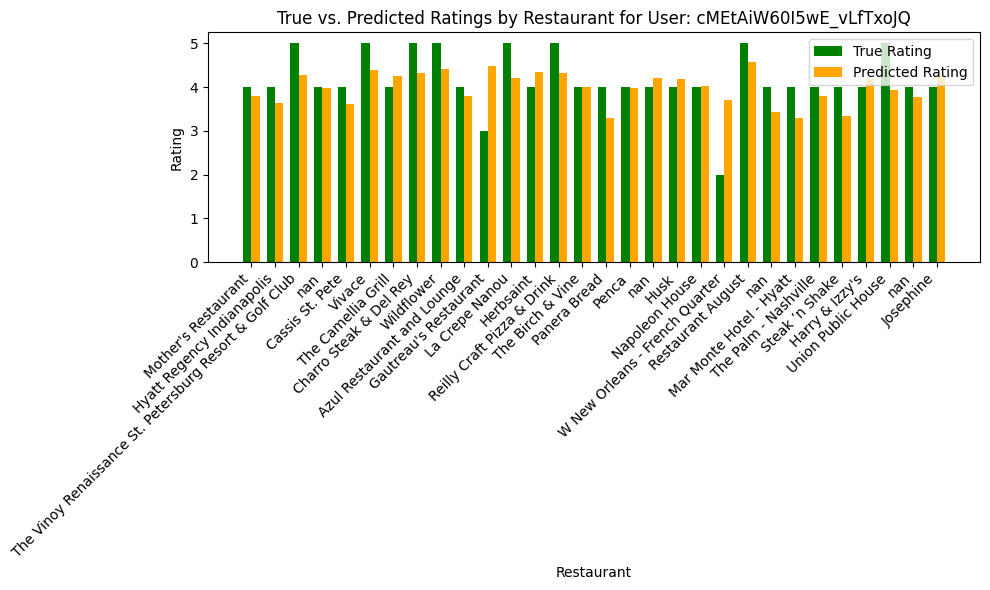

In [ ]:
import numpy as np

plt.figure(figsize=(10,6))
width = 0.35  # width of the bars
x = np.arange(len(user_performance_df))  # x locations for the restaurants

plt.bar(x - width/2, user_performance_df['true_rating'], width=width, label='True Rating', color='green')
plt.bar(x + width/2, user_performance_df['predicted_rating'], width=width, label='Predicted Rating', color='orange')

plt.xlabel('Restaurant')
plt.ylabel('Rating')
plt.title(f"True vs. Predicted Ratings by Restaurant for User: {sample_user}")
plt.xticks(x, user_performance_df['name'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

### Bandit

In [ ]:
import random
from collections import defaultdict
import pandas as pd

def get_top_n(predictions, n=50, solve_ties=False):
    """
    Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions: A list of Surprise Prediction objects.
        n: Number of recommendation items to return for each user.
        solve_ties: If True, break ties randomly.

    Returns:
        A dictionary mapping user_id to a list of tuples (item_id, predicted_rating).
    """
    top_n = defaultdict(list)

    # Group predictions by user
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort each user's predictions by predicted rating (descending) and keep top n
    for uid, user_ratings in top_n.items():
        if solve_ties:
            user_ratings.sort(key=lambda x: (x[1], random.random()), reverse=True)
        else:
            user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_n_cf = get_top_n(predictions, n=50)

In [ ]:
catalog = [trainset.to_raw_iid(inner_iid) for inner_iid in trainset.all_items()]
print("Catalog size:", len(catalog))

Catalog size: 51840


In [ ]:
def epsilon_greedy_recommendations(user, cf_recs, catalog, n=None, epsilon=0.1):
    """
    Return top-N recommendations for a user with epsilon-greedy exploration.

    Args:
        user: The user_id.
        cf_recs: List of tuples (item_id, predicted_rating) from CF.
        catalog: List of all item_ids available.
        n: Number of recommendations to consider. If None or greater than len(cf_recs),
           use the full length of cf_recs.
        epsilon: Fraction of recommendations to replace with random exploration.

    Returns:
        A list of recommendations (item_id, predicted_rating), with some items replaced
        by random selections.
    """
    # Use the available number of recommendations if n is not provided or too high.
    if n is None or n > len(cf_recs):
        n = len(cf_recs)
    else:
        # Otherwise, slice the recommendations to the top n items.
        cf_recs = cf_recs[:n]

    # Determine the number of items to explore.
    n_explore = max(1, int(epsilon * n))

    # Randomly select indices to replace within the available range (0 to n-1)
    indices_to_replace = random.sample(range(n), n_explore)

    # Create a copy of the recommendations list so that we don't modify the original.
    new_recs = cf_recs.copy()

    # Replace selected indices with random items from the catalog.
    for idx in indices_to_replace:
        random_item = random.choice(catalog)
        new_recs[idx] = (random_item, None)  # No predicted rating for a random item

    return new_recs

In [ ]:
# Example usage:
sample_user = list(top_n_cf.keys())[0]
cf_recs_sample = top_n_cf[sample_user]
epsilon_recs = epsilon_greedy_recommendations(sample_user, cf_recs_sample, catalog, n=50, epsilon=0.1)
print(f"Epsilon-Greedy Recommendations for user {sample_user}:")
epsilon_recs

Epsilon-Greedy Recommendations for user nlQGyti20c07rpTSYYoNZQ:


[('tjIIpbimdbi9Lrb-DoIzKg', None),
 ('SKKiHIOPKD3wdf0heTBfZw', 4.365640261321092),
 ('x5c_Lna3CYLQH4pAXFCBLg', 4.352872929565529),
 ('33zxFqIOe6Yg8qPXKkhUjg', 4.287326607377241),
 ('B1OjiK9Bx5t_mIm9I6mZ-Q', 4.258920878862756),
 ('-KhT2eqHZUj-Sqz3xkt-kw', 4.2543171675179074),
 ('Djg4suxDMaSwmR_RkrxYBw', 4.253874805990393),
 ('C5ZOzlslhMxRJDjBDV3KoQ', 4.2430308690054845),
 ('4QUPNvG8MC2t2NTngpNgBg', 4.022329514681399),
 ('J1XdgoK5-wabYDTGKAIzCQ', 4.012415280192797),
 ('uHqEKWJm8JBcRWiH97c1Cw', 3.9695129398309255),
 ('qDheewhaZNDWLfpsrrrRiw', 3.9475651913095158),
 ('HuawlT4tXzCXL8ftyvCZ0Q', 3.931034481841763),
 ('oF3QPsczR9ZiXPK89tdJaA', 3.9255249782042836),
 ('7EhTT4iEuA7JaaWA-eI3Qw', 3.9200593949282982),
 ('mFhZpY_IqvD-b2Ir3MSXMw', 3.913331260039626),
 ('2N97axWHko3rzyzOGCxxBA', 3.8667483006505186),
 ('FlrkiVnHN8K37q9WzJi_ug', 3.8511970999072984),
 ('PQ0QbT5I6V8JvOm0NRFlFw', 3.8481432672920364),
 ('Ucl9Vo5lwrUmYbV8Dv8X5g', 3.819946885306954),
 ('frQaWy1V0Mwn0uz6pU3IDA', None),
 ('30OhTA


⸻
Summary

What:
- The code creates an epsilon-greedy recommendation list that blends high-confidence CF recommendations with a small percentage of random items.

How:
- It takes the top-50 CF recommendations for a user, then replaces about 10% of those with random items from the catalog.

Why:
- This exploration mechanism helps the system discover new or less-reviewed restaurants, ensuring a balanced and dynamic recommendation experience that can improve user engagement and potentially lead to discovering hidden gems.

This approach is a practical application of bandit algorithms in recommender systems, showing both the technical mechanism and the business value of balancing exploration and exploitation.